In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Define the payoff matrix
# Format: (player1_action, player2_action) -> (player1_reward, player2_reward)
# 0: defect, 1: cooperate
T = 5  # Temptation to defect
R = 3  # Reward for mutual cooperation
P = 1  # Punishment for mutual defection
S = 0  # Sucker's payoff

payoff_matrix = {
    (0, 0): (P, P),  # Both defect
    (0, 1): (T, S),  # Player 1 defects, Player 2 cooperates
    (1, 0): (S, T),  # Player 1 cooperates, Player 2 defects
    (1, 1): (R, R)   # Both cooperate
}

# Modified PlayerRNN forward method
class PlayerRNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=64):
        super(PlayerRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden=None):
        if hidden is None:
            # Correct hidden state initialization
            hidden = torch.zeros(1, x.size(0), self.hidden_size)
        output, hidden = self.rnn(x, hidden)
        output = self.fc(output)
        output = self.sigmoid(output)
        return output, hidden

In [ ]:
def play_episode(player1, player2, num_iterations=150, gamma=0.96, start_nice=False):
    hidden1, hidden2 = None, None
    state = torch.randint(0, 2, (1, 1, 2), dtype=torch.float32) if not start_nice else torch.tensor([[[1., 1.]]], dtype=torch.float32)
    log_probs1, log_probs2, rewards1, rewards2 = [], [], [], []
    for _ in range(num_iterations):
        p1_prob, hidden1 = player1(state, hidden1)
        p2_prob, hidden2 = player2(state, hidden2)
        p1_dist = torch.distributions.Bernoulli(p1_prob.squeeze(1))
        p2_dist = torch.distributions.Bernoulli(p2_prob.squeeze(1))
        p1_action = p1_dist.sample()
        p2_action = p2_dist.sample()
        log_probs1.append(p1_dist.log_prob(p1_action))
        log_probs2.append(p2_dist.log_prob(p2_action))
        r1, r2 = payoff_matrix[(int(p1_action.item()), int(p2_action.item()))]
        rewards1.append(r1)
        rewards2.append(r2)
        state = torch.tensor([[[p1_action.item(), p2_action.item()]]], dtype=torch.float32)

    # Compute discounted returns
    returns1, returns2 = [], []
    G1, G2 = 0, 0
    for r1, r2 in zip(reversed(rewards1), reversed(rewards2)):
        G1 = r1 + gamma * G1
        G2 = r2 + gamma * G2
        returns1.insert(0, G1)
        returns2.insert(0, G2)
    returns1 = torch.tensor(returns1)
    returns2 = torch.tensor(returns2)
    returns1 = (returns1 - returns1.mean()) / (returns1.std() + 1e-8)
    returns2 = (returns2 - returns2.mean()) / (returns2.std() + 1e-8)
    player1_loss = -torch.stack(log_probs1) * returns1
    player2_loss = -torch.stack(log_probs2) * returns2
    return player1_loss.sum(), player2_loss.sum(), sum(rewards1), sum(rewards2)

In [ ]:
def train_players(player1, player2, num_episodes=1000, num_iterations=100, learning_rate=0.01, gamma=0.96):
    player1_optimizer = optim.Adam(player1.parameters(), lr=learning_rate)
    player2_optimizer = optim.Adam(player2.parameters(), lr=learning_rate)

    for episode in range(num_episodes):
        player1_loss, player2_loss, player1_rewards, player2_rewards = play_episode(player1,
                                                                    player2, num_iterations, gamma)

        # Update parameters
        player1_optimizer.zero_grad()
        player1_loss.backward()
        player1_optimizer.step()

        player2_optimizer.zero_grad()
        player2_loss.backward()
        player2_optimizer.step()

        if episode % 500 == 0:
            player1_avg_reward = player1_rewards / num_iterations
            player2_avg_reward = player2_rewards / num_iterations
            print(f"Episode {episode}: Player 1 avg reward = {player1_avg_reward}, "
                  f"Player 2 avg reward = {player2_avg_reward}")

In [ ]:
# Create players
player1 = PlayerRNN()
player2 = PlayerRNN()

# Train players
train_players(player1, player2, num_episodes=20001, num_iterations=100, learning_rate=0.0001, gamma=0.98)

Episode 0: Player 1 avg reward = 2.01, Player 2 avg reward = 2.76
Episode 100: Player 1 avg reward = 2.27, Player 2 avg reward = 2.22


KeyboardInterrupt: 

In [ ]:
# Define fixed strategies
class AlwaysDefect(nn.Module):
    def forward(self, x, hidden=None):
        return torch.tensor([[[0.0]]]), None

class AlwaysCooperate(nn.Module):
    def forward(self, x, hidden=None):
        return torch.tensor([[[1.0]]]), None

class TitForTat(nn.Module):
    def forward(self, x, hidden=None):
        opponent_last_action = x[0, -1, 0]
        return torch.tensor([[[opponent_last_action]]], dtype=torch.float32), None

class TitForTwoTats(nn.Module):
    """Only defects if opponent defects twice in a row"""
    def __init__(self):
        super(TitForTwoTats, self).__init__()
        self.prev_action = 1.0  # Start assuming cooperation

    def forward(self, x, hidden=None):
        opponent_last_action = x[0, -1, 0]
        result = 1.0  # Default to cooperation

        if opponent_last_action == 0.0 and self.prev_action == 0.0:
            result = 0.0  # Defect after two consecutive defections

        self.prev_action = opponent_last_action
        return torch.tensor([[[result]]]), None

class Grudger(nn.Module):
    """Cooperates until opponent defects once, then always defects"""
    def __init__(self):
        super(Grudger, self).__init__()
        self.has_defected = False

    def forward(self, x, hidden=None):
        opponent_last_action = x[0, -1, 0]

        if opponent_last_action == 0.0:
            self.has_defected = True

        result = 0.0 if self.has_defected else 1.0
        return torch.tensor([[[result]]]), None

class Random(nn.Module):
    """Randomly cooperates or defects with specified probability"""
    def __init__(self, p_cooperate=0.5):
        super(Random, self).__init__()
        self.p_cooperate = p_cooperate

    def forward(self, x, hidden=None):
        action = 1.0 if torch.rand(1).item() < self.p_cooperate else 0.0
        return torch.tensor([[[action]]]), None

class GenerousTitForTat(nn.Module):
    """Like Tit-for-Tat but occasionally forgives defections (10% chance)"""
    def forward(self, x, hidden=None):
        opponent_last_action = x[0, -1, 0]

        # 10% chance to cooperate even if opponent defected
        if opponent_last_action == 0.0 and torch.rand(1).item() < 0.1:
            return torch.tensor([[[1.0]]]), None

        return torch.tensor([[[opponent_last_action]]]), None

class Pavlov(nn.Module):
    """Win-Stay, Lose-Shift strategy. Changes strategy if previous outcome was poor."""
    def __init__(self):
        super(Pavlov, self).__init__()
        self.prev_my_action = 1.0  # Start with cooperation

    def forward(self, x, hidden=None):
        my_last_action = self.prev_my_action
        opponent_last_action = x[0, -1, 0]

        # Win-Stay, Lose-Shift logic
        # "Win" means either mutual cooperation (1,1) or successful defection (0,1)
        # "Lose" means either mutual defection (0,0) or being suckered (1,0)
        if my_last_action == opponent_last_action:  # If both made same choice: (1,1) or (0,0)
            result = my_last_action  # Stay with previous action
        else:  # If different choices: (1,0) or (0,1)
            result = 1.0 - my_last_action  # Shift to opposite

        self.prev_my_action = result
        return torch.tensor([[[result]]]), None

class Majority(nn.Module):
    """Does what the opponent has done most frequently"""
    def __init__(self):
        super(Majority, self).__init__()
        self.cooperate_count = 0
        self.defect_count = 0

    def forward(self, x, hidden=None):
        opponent_last_action = x[0, -1, 0]

        # Update counts
        if opponent_last_action == 1.0:
            self.cooperate_count += 1
        else:
            self.defect_count += 1

        # Choose based on majority
        if self.cooperate_count > self.defect_count:
            return torch.tensor([[[1.0]]]), None
        elif self.defect_count > self.cooperate_count:
            return torch.tensor([[[0.0]]]), None
        else:
            return torch.tensor([[[1.0]]]), None  # Tie-breaking with cooperation

class Gradual(nn.Module):
    """Starts cooperating, then defects n times after nth defection, then forgives"""
    def __init__(self):
        super(Gradual, self).__init__()
        self.defection_count = 0  # Count of opponent's defections
        self.retaliation_counter = 0  # How many more times to defect
        self.retaliating = False  # Currently in retaliation mode?
        self.forgiveness_counter = 0  # Counter for forgiveness phase

    def forward(self, x, hidden=None):
        if self.retaliating:
            if self.retaliation_counter > 0:
                self.retaliation_counter -= 1
                return torch.tensor([[[0.0]]]), None  # Continue defecting
            else:
                self.retaliating = False
                self.forgiveness_counter = 2  # 2 cooperation moves for forgiveness

        if self.forgiveness_counter > 0:
            self.forgiveness_counter -= 1
            return torch.tensor([[[1.0]]]), None  # Cooperate during forgiveness

        opponent_last_action = x[0, -1, 0]

        if opponent_last_action == 0.0:  # Opponent defected
            self.defection_count += 1
            self.retaliation_counter = self.defection_count  # Defect n times after nth defection
            self.retaliating = True
            return torch.tensor([[[0.0]]]), None

        return torch.tensor([[[1.0]]]), None  # Default to cooperation

class MajorityOfThree(nn.Module):
    """Bases decision on majority of opponent's last three moves"""
    def __init__(self):
        super(MajorityOfThree, self).__init__()
        self.history = [1.0, 1.0, 1.0]  # Initial assumption (cooperative)

    def forward(self, x, hidden=None):
        opponent_last_action = x[0, -1, 0]

        # Update history
        self.history.pop(0)
        self.history.append(opponent_last_action)

        # Determine majority
        cooperate_count = sum(1 for a in self.history if a > 0.5)

        # Return 1 if majority cooperated, 0 otherwise
        result = 1.0 if cooperate_count >= 2 else 0.0
        return torch.tensor([[[result]]]), None

class Prober(nn.Module):
    """Tests opponent with initial defection, then plays TFT or Always Defect"""
    def __init__(self):
        super(Prober, self).__init__()
        self.move_counter = 0
        self.opponent_moves = []
        self.strategy_determined = False
        self.use_tft = True

    def forward(self, x, hidden=None):
        self.move_counter += 1

        # First move: defect
        if self.move_counter == 1:
            return torch.tensor([[[0.0]]]), None

        opponent_last_action = x[0, -1, 0]
        self.opponent_moves.append(opponent_last_action)

        # Determine strategy after move 3
        if self.move_counter == 4 and not self.strategy_determined:
            # If opponent cooperated after our initial defection,
            # they might be forgiving, so switch to always defect
            if self.opponent_moves[0] == 1.0 and self.opponent_moves[1] == 1.0:
                self.use_tft = False
            self.strategy_determined = True

        # Use determined strategy
        if self.strategy_determined:
            if self.use_tft:
                return torch.tensor([[[opponent_last_action]]]), None
            else:
                return torch.tensor([[[0.0]]]), None

        # Moves 2-3: cooperate to test opponent
        return torch.tensor([[[1.0]]]), None

In [ ]:
import matplotlib.pyplot as plt
import torch

def evaluate_against_fixed(player, num_episodes=1, num_iterations=100):
    fixed_strategies = {
        'AlwaysDefect': AlwaysDefect(),
        'AlwaysCooperate': AlwaysCooperate(),
        'TitForTat': TitForTat(),
        'TitForTwoTats': TitForTwoTats(),
        'Grudger': Grudger(),
        'Random': Random(),
        'GenerousTitForTat': GenerousTitForTat(),
        'Pavlov': Pavlov(),
        'Majority': Majority(),
        'Gradual': Gradual(),
        'MajorityOfThree': MajorityOfThree(),
        'Prober': Prober()
    }

    # Set up a figure with subplots
    fig, axes = plt.subplots(6, 2, figsize=(12, 16))

    # To store reward info for each strategy
    rewards_info = []

    for i, (name, strategy) in enumerate(fixed_strategies.items()):
        total_player_reward = 0
        total_opponent_reward = 0

        all_player_actions = []
        all_strategy_actions = []

        for episode in range(num_episodes):
            player_hidden = None
            strategy_hidden = None
            state = torch.tensor([[[1., 1.]]])

            episode_player_reward = 0
            episode_opponent_reward = 0

            player_actions = []
            strategy_actions = []

            for _ in range(num_iterations):
                player_prob, player_hidden = player(state, player_hidden)
                player_action = 1 if player_prob.item() > 0.5 else 0

                strategy_prob, strategy_hidden = strategy(state, strategy_hidden)
                strategy_action = 1 if strategy_prob.item() > 0.5 else 0

                p_reward, s_reward = payoff_matrix[(player_action, strategy_action)]
                episode_player_reward += p_reward
                episode_opponent_reward += s_reward

                player_actions.append(player_action)
                strategy_actions.append(strategy_action)

                state = torch.tensor([[[player_action, strategy_action]]], dtype=torch.float32)

            total_player_reward += episode_player_reward
            total_opponent_reward += episode_opponent_reward

            all_player_actions.append(player_actions)
            all_strategy_actions.append(strategy_actions)

        # Store the reward data for later use in the plot
        rewards_info.append((name, total_player_reward, total_opponent_reward))

        # Plot the actions of the last episode for this strategy
        ax = axes[i // 2, i % 2]
        ax.plot(all_player_actions[-1], label='Player Actions (1=Cooperate, 0=Defect)')
        ax.plot(all_strategy_actions[-1], label=f'{name} Actions (1=Cooperate, 0=Defect)')
        ax.set_title(f'Actions over time against {name}\nPlayer Reward: {total_player_reward:.2f}, Fixed Strategy Reward: {total_opponent_reward:.2f}\nTotal Reward generated: {total_player_reward + total_opponent_reward:.2f}')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Action')
        ax.grid(True)

    # Adjust the layout and display the figure with all subplots
    fig.suptitle('Games Against Fixed Strategies\n(Blue: Player moves, Orange: Strategy moves)\n')
    plt.tight_layout()
    plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Payoff matrix setup (as above)
# Player RNN class (as above)
# Fixed strategy classes (as above)

# Play episode function (as above)
# Train players function (as above)

def evaluate_players(player1, player2, num_iterations=100):
    player1.eval() if hasattr(player1, 'eval') else None
    player2.eval() if hasattr(player2, 'eval') else None

    with torch.no_grad():
        # Initialize state and hidden states
        state = torch.tensor([[[1.,1.]]])
        hidden1, hidden2 = None, None

        player1_actions, player2_actions = [], []
        player1_rewards, player2_rewards = 0, 0

        for _ in range(num_iterations):
            # Get action probabilities
            player1_prob, hidden1 = player1(state, hidden1)
            player2_prob, hidden2 = player2(state, hidden2)

            # Deterministic actions during evaluation
            player1_action = 1 if player1_prob.item() > 0.5 else 0
            player2_action = 1 if player2_prob.item() > 0.5 else 0

            player1_actions.append(player1_action)
            player2_actions.append(player2_action)

            # Calculate rewards
            p1_reward, p2_reward = payoff_matrix[(player1_action, player2_action)]
            player1_rewards += p1_reward
            player2_rewards += p2_reward

            # Update state
            state = torch.tensor([[[player1_action, player2_action]]], dtype=torch.float32)

    # Return to training mode
    player1.train() if hasattr(player1, 'train') else None
    player2.train() if hasattr(player2, 'train') else None

    # Display statistics
    print(f"Player 1 cooperation rate: {sum(player1_actions)/len(player1_actions)}")
    print(f"Player 2 cooperation rate: {sum(player2_actions)/len(player2_actions)}")

    return (player1_actions, player2_actions), (player1_rewards, player2_rewards)

def visualize_results(player1_actions, player2_actions):
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(player1_actions)
    plt.title('Player 1 Actions (1=Cooperate, 0=Defect)')
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(player2_actions)
    plt.title('Player 2 Actions (1=Cooperate, 0=Defect)')
    plt.grid()

    plt.tight_layout()
    plt.savefig('ipd_actions.png')
    plt.show()

Player 1 cooperation rate: 0.99
Player 2 cooperation rate: 1.0


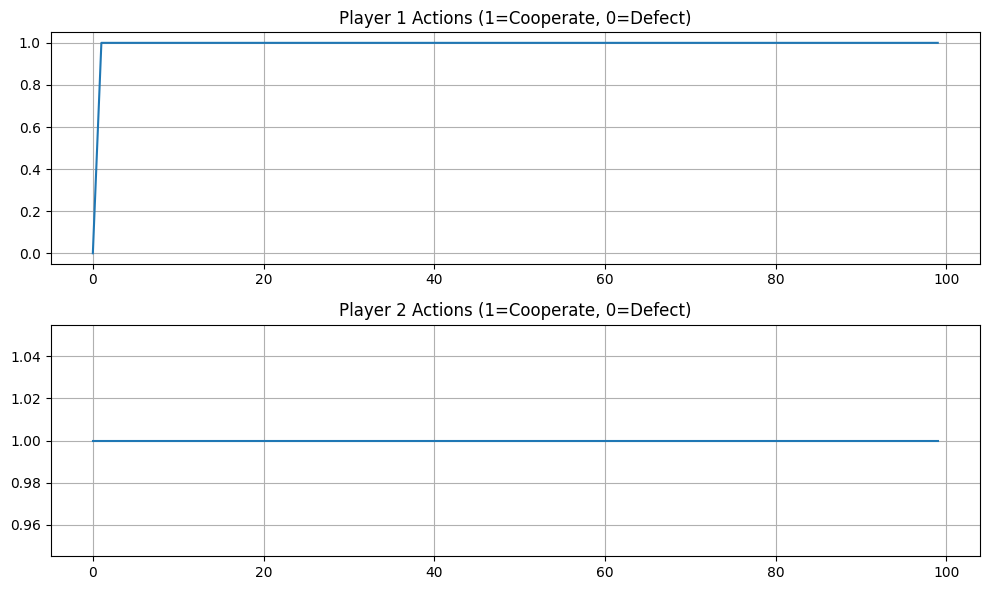

In [ ]:
# Evaluate players
actions, rewards = evaluate_players(player1, player2, 100)
visualize_results(actions[0], actions[1])

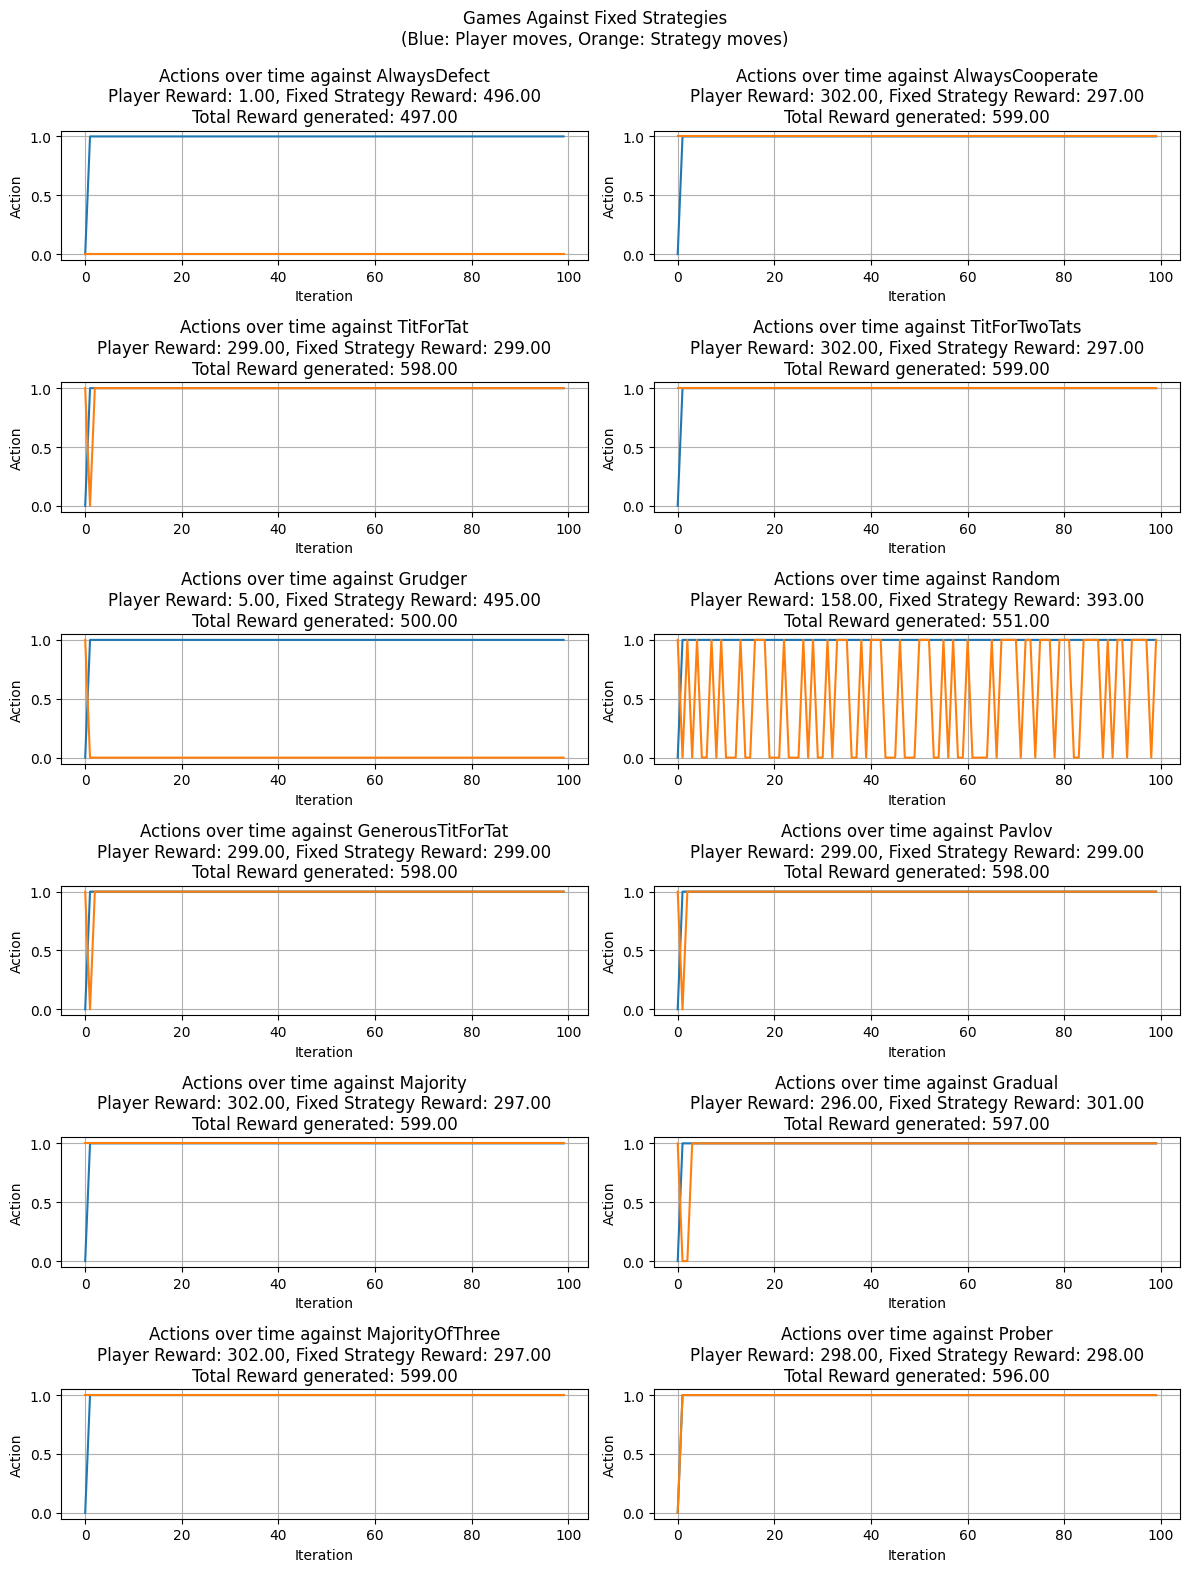

In [ ]:
# Evaluate against fixed strategies
evaluate_against_fixed(player1)

In [ ]:
player2 = PlayerRNN()
player2.load_state_dict(torch.load('player2.pth'))

<All keys matched successfully>

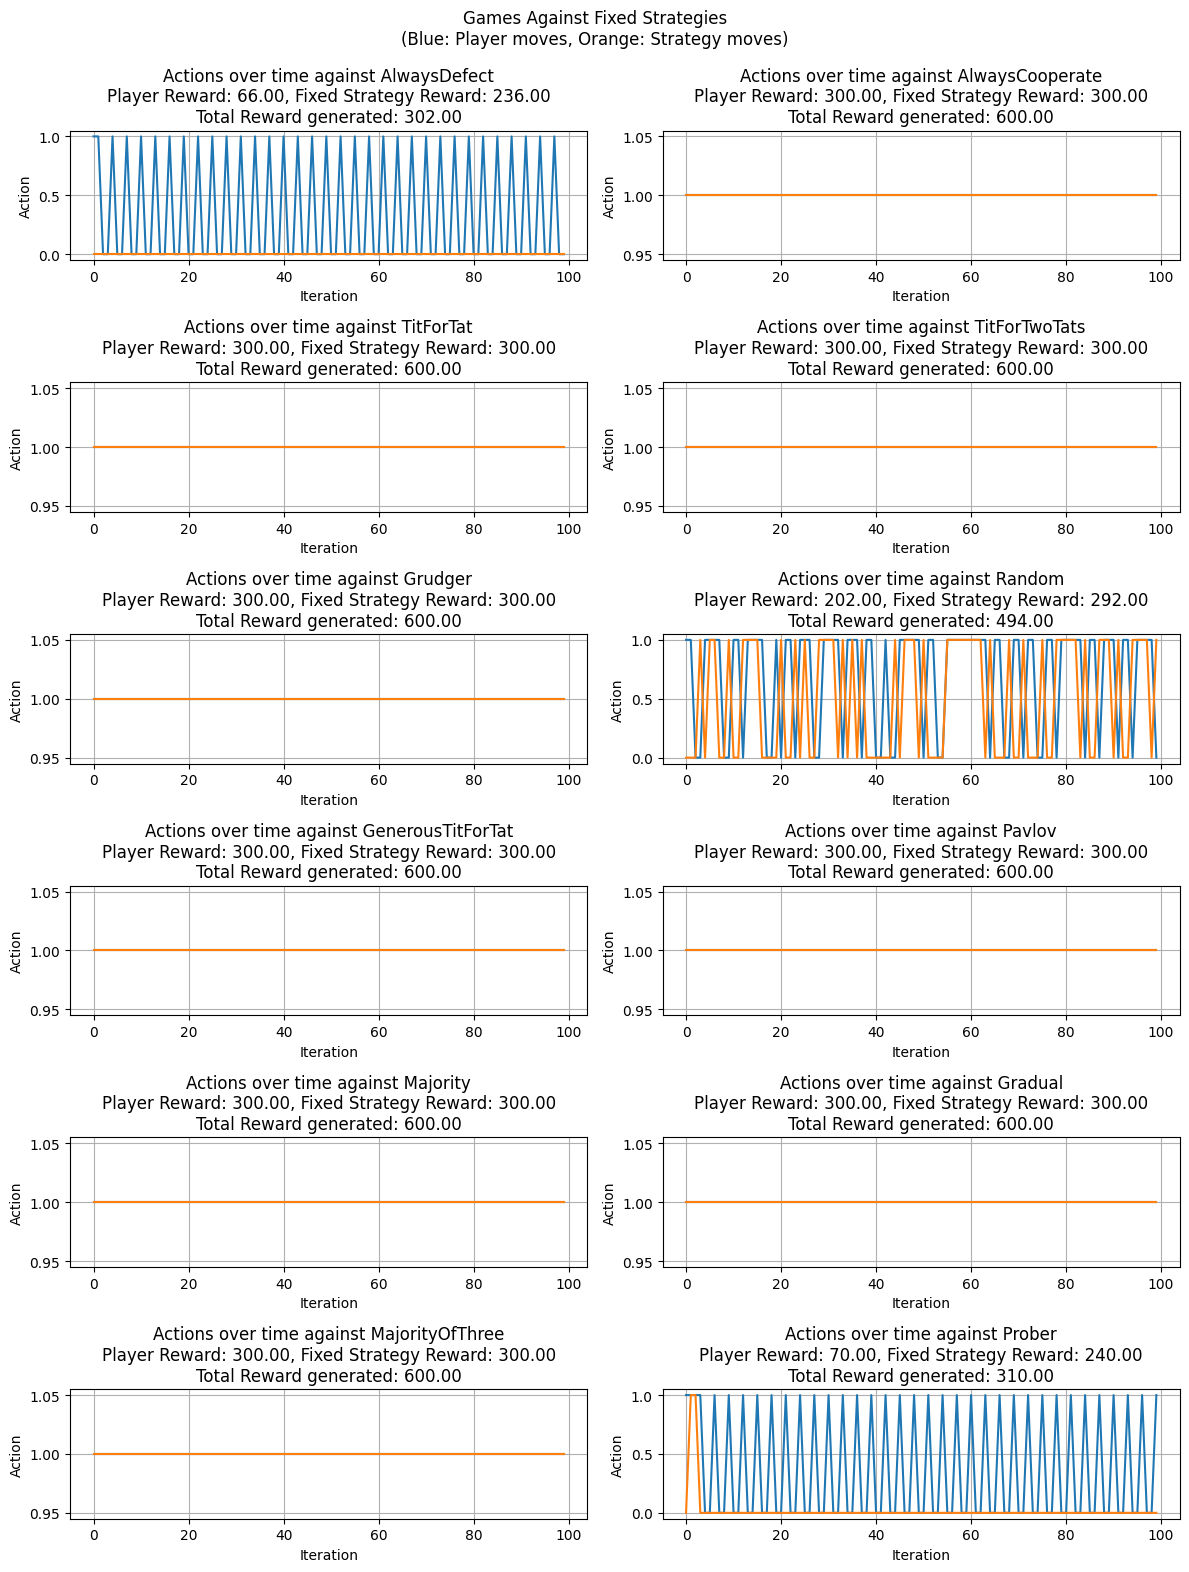

In [ ]:
evaluate_against_fixed(player2)

In [ ]:
def interactive_play(player2, num_rounds=20):
    """Play against the trained AI model"""
    player2.eval()
    hidden = None
    state = torch.tensor([[[1., 1.]]])  # Initial state

    total_human = 0
    total_ai = 0
    history = []

    print("\n=== Interactive Prisoner's Dilemma ===")
    print("Enter 0 to DEFECT, 1 to COOPERATE")

    for round in range(1, num_rounds+1):
        # Get human input
        while True:
            try:
                human_action = int(input(f"\nRound {round}/{num_rounds} - Your move (0/1): "))
                if human_action in {0, 1}:
                    break
                print("Invalid input! Please enter 0 or 1")
            except ValueError:
                print("Invalid input! Please enter 0 or 1")

        # Get AI move
        with torch.no_grad():
            ai_prob, hidden = player2(state, hidden)
            ai_action = 1 if ai_prob.item() > 0.5 else 0

        # Calculate rewards
        human_reward, ai_reward = payoff_matrix[(human_action, ai_action)]

        # Update totals
        total_human += human_reward
        total_ai += ai_reward

        # Store history
        history.append({
            'round': round,
            'human': human_action,
            'ai': ai_action,
            'human_reward': human_reward,
            'ai_reward': ai_reward
        })

        # Update state for next round
        state = torch.tensor([[[float(human_action), float(ai_action)]]])

        # Print results
        print(f"\nYour action: {'DEFECT' if human_action == 0 else 'COOPERATE'}")
        print(f"AI action:   {'DEFECT' if ai_action == 0 else 'COOPERATE'}")
        print(f"Your reward: {human_reward}")
        print(f"AI reward:   {ai_reward}")

    # Final results
    print("\n=== Game Results ===")
    print(f"Your total score: {total_human}")
    print(f"AI total score:   {total_ai}")
    print(f"Combined total:   {total_human + total_ai}")

    # Display strategy analysis
    human_coop_rate = sum(h['human'] for h in history) / num_rounds
    ai_coop_rate = sum(h['ai'] for h in history) / num_rounds
    print(f"\nYour cooperation rate: {human_coop_rate:.1%}")
    print(f"AI cooperation rate:   {ai_coop_rate:.1%}")

    # Plot interaction history
    plt.figure(figsize=(12, 6))
    plt.plot([h['human'] for h in history], 'o-', label='Your Actions')
    plt.plot([h['ai'] for h in history], 'x-', label='AI Actions')
    plt.yticks([0, 1], ['Defect', 'Cooperate'])
    plt.xlabel('Round')
    plt.title('Interaction History')
    plt.legend()
    plt.grid(True)
    plt.show()


=== Interactive Prisoner's Dilemma ===
Enter 0 to DEFECT, 1 to COOPERATE

Round 1/20 - Your move (0/1): 1

Your action: COOPERATE
AI action:   COOPERATE
Your reward: 3
AI reward:   3

Round 2/20 - Your move (0/1): 1

Your action: COOPERATE
AI action:   COOPERATE
Your reward: 3
AI reward:   3

Round 3/20 - Your move (0/1): 0

Your action: DEFECT
AI action:   COOPERATE
Your reward: 5
AI reward:   0

Round 4/20 - Your move (0/1): 0

Your action: DEFECT
AI action:   COOPERATE
Your reward: 5
AI reward:   0

Round 5/20 - Your move (0/1): 0

Your action: DEFECT
AI action:   COOPERATE
Your reward: 5
AI reward:   0

Round 6/20 - Your move (0/1): 0

Your action: DEFECT
AI action:   COOPERATE
Your reward: 5
AI reward:   0

Round 7/20 - Your move (0/1): 0

Your action: DEFECT
AI action:   COOPERATE
Your reward: 5
AI reward:   0

Round 8/20 - Your move (0/1): 0

Your action: DEFECT
AI action:   COOPERATE
Your reward: 5
AI reward:   0

Round 9/20 - Your move (0/1): 0

Your action: DEFECT
AI action:

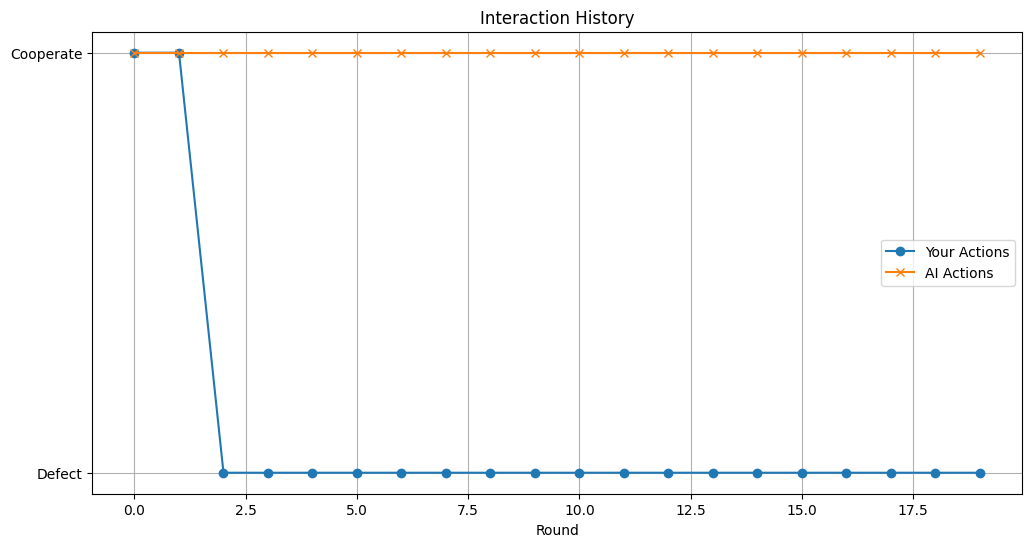

In [ ]:
interactive_play(player2)

In [ ]:
torch.save(player1.state_dict(), 'player1.pth')
torch.save(player2.state_dict(), 'player2.pth')